In [116]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
%matplotlib inline


import importlib
from globals import *
import cell
import tissue
import time

importlib.reload(cell)
importlib.reload(tissue)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'tissue' from '/Users/noammizrachi/Documents/Msc/karzbrun project/code/vertex_model/tissue.py'>

In [117]:
T = tissue.Tissue(cell_radius=cell_radius, num_cols=10, num_rows=10)

Node (1.0, 0.0): [-4.82601033e-06  0.00000000e+00]
Node (0.5, 0.86603): [-4.23992728e-07 -6.96890791e-06]
Node (-0.5, 0.86603): [ 4.23992728e-07 -6.96890791e-06]
Node (-1.0, 0.0): [-0.21243074  0.        ]
Node (-0.5, -0.86603): [-0.1062202  -0.18397139]
Node (0.5, -0.86603): [ 0.1062202  -0.18397139]
Node (2.5, 0.86603): [ 4.23992728e-07 -6.96890791e-06]
Node (2.0, 1.73205): [-4.23992728e-07  6.96890791e-06]
Node (1.0, 1.73205): [4.23992728e-07 6.96890791e-06]
Node (2.0, -0.0): [4.82601033e-06 0.00000000e+00]
Node (4.0, 0.0): [-4.82601033e-06  0.00000000e+00]
Node (3.5, 0.86603): [-4.23992728e-07 -6.96890791e-06]
Node (2.5, -0.86603): [-0.1062202  -0.18397139]
Node (3.5, -0.86603): [ 0.1062202  -0.18397139]
Node (5.5, 0.86603): [ 4.23992728e-07 -6.96890791e-06]
Node (5.0, 1.73205): [-4.23992728e-07  6.96890791e-06]
Node (4.0, 1.73205): [4.23992728e-07 6.96890791e-06]
Node (5.0, -0.0): [4.82601033e-06 0.00000000e+00]
Node (7.0, 0.0): [-4.82601033e-06  0.00000000e+00]
Node (6.5, 0.86603

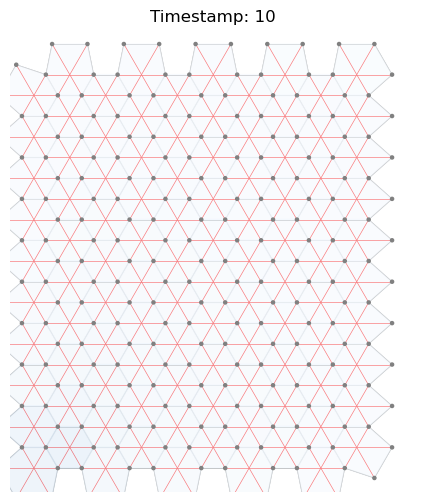

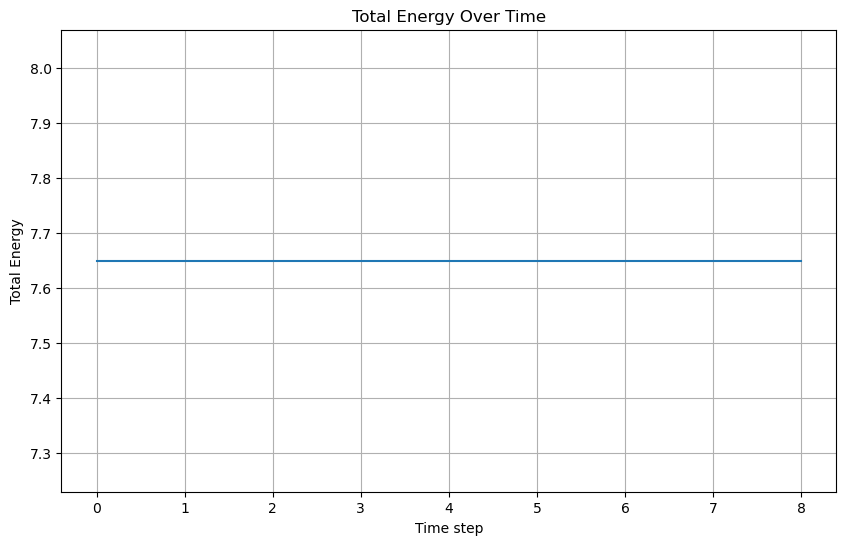

In [118]:
# add some pertubations to check plotting
# original_pos = nx.get_node_attributes(T.graph, 'pos').copy()
# for cell in T.cells:
#     cell.height = np.random.uniform(0.1, 1.0)
#     pts = np.array([original_pos[n] for n in cell.nodes])
#     center = pts.mean(axis=0)
#     for i, n in enumerate(cell.nodes):
#         x, y = original_pos[n]
#         vx, vy = x - center[0], y - center[1]
#         length = np.hypot(vx, vy) or 1.0
#         ux, uy = vx/length, vy/length
#         shift_x = np.random.normal(0, 0.1)
#         shift_y = np.random.normal(0, 0.1)
#         new_pos = (x + ux*shift_x, y + uy*shift_y)
#         T.graph.nodes[n]['pos'] = new_pos


time_limit = 10
total_energy = []
for t in range(1, time_limit):
    # Create a new figure each time
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot tissue
    ax.set_title(f"Timestamp: {t}")
    T.plot_tissue(ax=ax)
    
    # Display the plot
    plt.tight_layout()
    display(fig)
    plt.close(fig)
    
    # For animations in Jupyter notebooks
    clear_output(wait=True)
    time.sleep(0.5)
    
    # Update for next iteration
    # T.compute_all_forces(['spring', 'line_tension'])
    T.compute_all_forces(['spring'])
    T.update_positions(dt=0.5)
    T.update_heights()
    total_energy.append(T.compute_total_energy())

    for node in T.graph.nodes:
        print(f"Node {node}: {T.graph.nodes[node]['force']}")


# Create final figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Timestamp: {time_limit}")
T.plot_tissue(ax=ax)
plt.show()



#graph of total eneergy in time:
plt.plot(total_energy)
plt.xlabel("Time step")
plt.ylabel("Total Energy")
plt.title("Total Energy Over Time")
plt.grid(True)
plt.show()